# Computer Vision - Project

In [1]:
#Importing all the necessary Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras.applications.mobilenet import preprocess_input, MobileNet
from tensorflow.keras.layers import Concatenate, Conv2D, Reshape, UpSampling2D, ZeroPadding2D, Convolution2D, MaxPooling2D, Dropout, Flatten, Activation
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import optimizers, losses
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau 

from PIL import Image

from google.colab.patches import cv2_imshow

from zipfile import ZipFile
import glob
import cv2
import os
import warnings
warnings.filterwarnings('ignore')
import gc
import copy

## Face Detection

### 1. Import and Understand the data [7 Marks]

#### 1A. Import and read ‘images.npy’. [1 Marks]

In [2]:
#Importing & Reading the 'image.npy' file
images = np.load('/content/drive/MyDrive/Python - Collab/12. Module-9_Computer Vision/Computer Vision - Project/images.npy', allow_pickle=True)

[[[207 216 227 255]
  [206 216 227 255]
  [207 216 227 255]
  ...
  [ 35  33  34 255]
  [ 35  33  34 255]
  [ 35  33  34 255]]

 [[207 216 227 255]
  [207 216 227 255]
  [207 216 227 255]
  ...
  [ 35  32  33 255]
  [ 35  33  34 255]
  [ 35  33  34 255]]

 [[207 216 227 255]
  [207 216 227 255]
  [207 215 227 255]
  ...
  [ 35  33  33 255]
  [ 35  33  34 255]
  [ 35  33  34 255]]

 ...

 [[ 31  21  17 255]
  [ 31  22  18 255]
  [ 31  22  18 255]
  ...
  [  0   1   4 255]
  [  0   1   4 255]
  [  0   1   4 255]]

 [[ 31  22  18 255]
  [ 31  22  18 255]
  [ 31  22  18 255]
  ...
  [  0   1   4 255]
  [  0   1   4 255]
  [  0   1   4 255]]

 [[ 31  22  18 255]
  [ 30  22  17 255]
  [ 31  22  18 255]
  ...
  [  0   1   4 255]
  [  0   1   4 255]
  [  0   1   4 255]]]


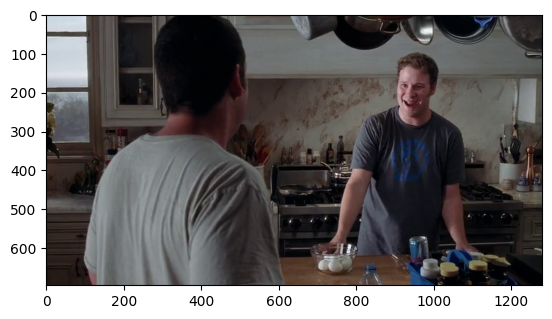

In [3]:
#Reading the Images
print(images[1][0]) #Display the array of image
plt.imshow(images[1][0]) #Display the image
plt.show()

In [4]:
#Printing the label of the images
print(images[1][1]) #Displaying the detials of the image

[{'label': ['Face'], 'notes': '', 'points': [{'x': 0.7053087757313109, 'y': 0.23260437375745527}, {'x': 0.7692307692307693, 'y': 0.36182902584493043}], 'imageWidth': 1280, 'imageHeight': 697}]


In [5]:
#Printing the shape of images
images.shape

(409, 2)

#### 1B. Split the data into Features(X) & labels(Y). Unify shape of all the images. [3 Marks]

In [6]:
#Defining necessary parameters
Img_Width = 224           #Width of Original Image
Img_Height = 224          #Height of Original Image

Imgm_Width = 224          #Width of Masked Image
Imgm_Height = 224         #Height of Masked Image

In [7]:
#Creating empty array for storing images detials
x = np.zeros((int(images.shape[0]), Img_Height, Img_Width, 3)) #Features
y = np.zeros((int(images.shape[0]), Imgm_Height, Imgm_Width)) #Labels

for index in range(images.shape[0]):
  img = images[index][0]
  res_img = cv2.resize(img, (Img_Height, Img_Width), interpolation=cv2.INTER_AREA) #Unifying the shape of all images
  try:
    res_img = res_img[:, :, :3] #Changing the channel of all images to 3 to unify the shape.
  except:
    continue
  x[index] = preprocess_input(np.array(res_img, dtype=np.float32))

  for i in images[index][1]:
    x1 = int(i['points'][0]['x'] * Imgm_Width)
    y1 = int(i['points'][0]['y'] * Imgm_Height)
    x2 = int(i['points'][1]['x'] * Imgm_Width)
    y2 = int(i['points'][1]['y'] * Imgm_Height)
    y[index][y1:y2, x1:x2] = 1

In [8]:
#Printing the shape of Features(x) & Labels(y)
print('Shape of x:', x.shape, '\n')
print('Shape of y:', y.shape)

Shape of x: (409, 224, 224, 3) 

Shape of y: (409, 224, 224)


#### 1C. Split the data into train and test[400:9]. [1 Marks]

In [9]:
#Splitting the dataset into train & test data (Train Data: 400 Nos., Test Data: 9 Nos.)
x_tr, x_te, y_tr, y_te = train_test_split(x, y, test_size=9, random_state=12)

In [10]:
#Printing the shape of test & train data
print('Shape of x_tr:', x_tr.shape)
print('Shape of x_te:', x_te.shape)
print('Shape of y_tr:', y_tr.shape)
print('Shape of y_te:', y_te.shape)

Shape of x_tr: (400, 224, 224, 3)
Shape of x_te: (9, 224, 224, 3)
Shape of y_tr: (400, 224, 224)
Shape of y_te: (9, 224, 224)


#### 1D.  Select random image from the train data and display original image and masked image. [2 Marks]

Random Image No.: [148] 

The Original [148] image:


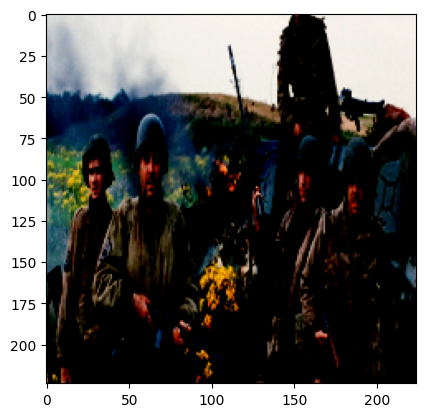



The Masked [148] image:


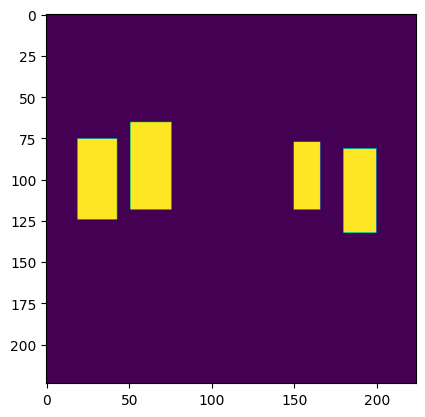

In [30]:
#Selecting a random image from the train data
n = np.random.randint(0, 401, 1) #Getting a random no.
print('Random Image No.:', n, '\n')

#Displaying the nth original image & masked image
print('The Original {} image:'.format(n))
plt.imshow(x_tr[int(n)])
plt.show()
print('\n')
print('The Masked {} image:'.format(n))
plt.imshow(y_tr[int(n)])
plt.show()

### 2.  Model building [11 Marks]

### 2A.  Design a face mask detection model. [4 Marks]

In [12]:
#Designing a face mask detection model
def mobilenet(trainable=True):
  mobile = MobileNet(input_shape=(Img_Height, Img_Width, 3), include_top=False, alpha=1, weights='imagenet')

  for layers in mobile.layers:
    layers.trainable = trainable
  
  block1 = mobile.get_layer('conv_pw_1_relu').output
  block2 = mobile.get_layer('conv_pw_3_relu').output
  block3 = mobile.get_layer('conv_pw_5_relu').output
  block4 = mobile.get_layer('conv_pw_11_relu').output
  block5 = mobile.get_layer('conv_pw_13_relu').output

  x = Concatenate()([UpSampling2D()(block5), block4])
  x = Concatenate()([UpSampling2D()(x), block3])
  x = Concatenate()([UpSampling2D()(x), block2])
  x = Concatenate()([UpSampling2D()(x), block1])
  x = UpSampling2D()(x)

  x = Conv2D(1, kernel_size=1, activation='sigmoid')(x)
  x = Reshape((Imgm_Height, Imgm_Width))(x)

  return Model(inputs=mobile.input, outputs=x)

#### 2B. Design your own Dice Coefficient and Loss function. [2 Marks]

In [13]:
#Designing Dice Coefficient
def dice_coefficient(y_true, y_pred):
  num = 2 * tf.reduce_sum(y_true*y_pred)
  deno = tf.reduce_sum(y_true + y_pred)

  return num/(deno + tf.keras.backend.epsilon())

In [14]:
#Designing Loss Function
def loss(y_true, y_pred):
  return losses.binary_crossentropy(y_true, y_pred) - tf.keras.backend.log(dice_coefficient(y_true, y_pred) + tf.keras.backend.epsilon())

#### 2C. Train and tune the model as required. [3 Marks]

In [15]:
#Generating the model & printing the summary
mobunet = mobilenet(False)
mobunet.summary()

17225924/17225924 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 112, 112, 32  128         ['conv1[0][0]']                  
                             

In [16]:
#Setting the optimizer
opt = optimizers.Adam(learning_rate=1e-3, beta_1=0.9, beta_2=0.999, weight_decay=0.0, amsgrad=False)

#Compiling the model
mobunet.compile(loss = loss, optimizer = opt, metrics=[dice_coefficient])

In [17]:
#Defining callbacks
checkpoint = ModelCheckpoint('mobunet.h5', monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True)
earlystop = EarlyStopping(monitor='val_loss', patience=10, verbose=1)
red_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-6, verbose=1)

callbacks = [checkpoint, earlystop, red_lr]

#Clearing the cache memory after each epoch to free up the memory
class GarbageCollectorCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    gc.collect()

In [18]:
#Fitting & Training the model
Mob_UNet = mobunet.fit(x_tr, y_tr, validation_data=(x_te, y_te), batch_size=10, epochs=50, verbose=1, callbacks=callbacks, use_multiprocessing=True, workers=8)

Epoch 1/50
40/40 [==============================] - ETA: 0s - loss: 1.3891 - dice_coefficient: 0.3945
Epoch 1: val_loss improved from inf to 0.77985, saving model to mobunet.h5
40/40 [==============================] - 320s 8s/step - loss: 1.3891 - dice_coefficient: 0.3945 - val_loss: 0.7798 - val_dice_coefficient: 0.5810 - lr: 0.0010
Epoch 2/50
40/40 [==============================] - ETA: 0s - loss: 0.8543 - dice_coefficient: 0.5613
Epoch 2: val_loss improved from 0.77985 to 0.67819, saving model to mobunet.h5
40/40 [==============================] - 319s 8s/step - loss: 0.8543 - dice_coefficient: 0.5613 - val_loss: 0.6782 - val_dice_coefficient: 0.6341 - lr: 0.0010
Epoch 3/50
40/40 [==============================] - ETA: 0s - loss: 0.7502 - dice_coefficient: 0.6048
Epoch 3: val_loss did not improve from 0.67819
40/40 [==============================] - 313s 8s/step - loss: 0.7502 - dice_coefficient: 0.6048 - val_loss: 0.6938 - val_dice_coefficient: 0.6454 - lr: 0.0010
Epoch 4/50
40/40

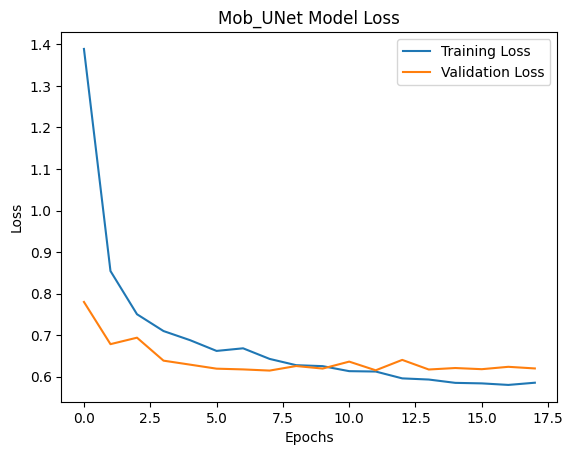

In [19]:
#Visualizing the Training & Validation Loss of the model
plt.plot(Mob_UNet.history['loss'])
plt.plot(Mob_UNet.history['val_loss'])
plt.title('Mob_UNet Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Training Loss', 'Validation Loss'])
plt.show()

#### 2D. Evaluate and share insights on performance of the model. [2 Marks]

In [20]:
#Evaluating the Model
evaluation = mobunet.evaluate(x_te, y_te, verbose=1)
print('The Loss of the "Mobunet" Model is:', evaluation[0])
print('The Dice-Coefficient of the "Mobunet" Model is:', evaluation[1])

1/1 [==============================] - 4s 4s/step - loss: 0.6197 - dice_coefficient: 0.6752
The Loss of the "Mobunet" Model is: 0.6197051405906677
The Dice-Coefficient of the "Mobunet" Model is: 0.6751958131790161


##### Insights:
- The pre-trained model 'MobileNet' on imagenet dataset was used as based model & further layers of UNet were added as UpSampling.
- The objective of the model was to detect the face in 409 images provided, out of which 400 images were used for training & 9 images for testing/validation.
- The model uses 'dice_coefficient' as evaluation metrics which was designed as a part of the project.
-  The original images were of the size (224, 224, 3) while the labels & predicted images were of size (28, 28).
- The model was trained to predict the faces accurately. For this, modelcheckpoint, early stopping & reduce learning rate was used as callbacks.

### 3. Test the model predictions on the test image: ‘image with index 3 in the test data’ and visualise the predicted masks on the faces in the image. [2 Marks]


The Original Image


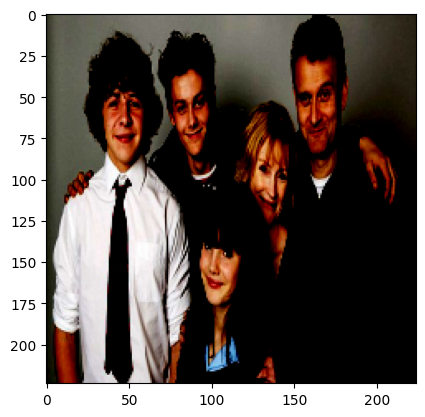

The Masked Image


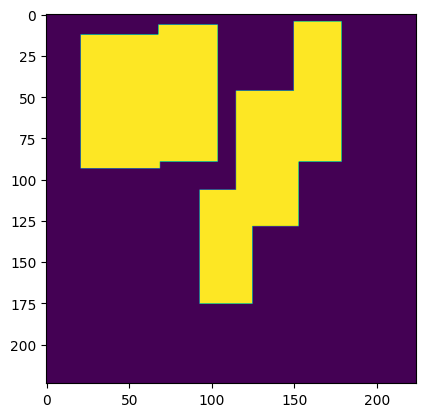

The Predicted Masked Image
1/1 [==============================] - 1s 1s/step


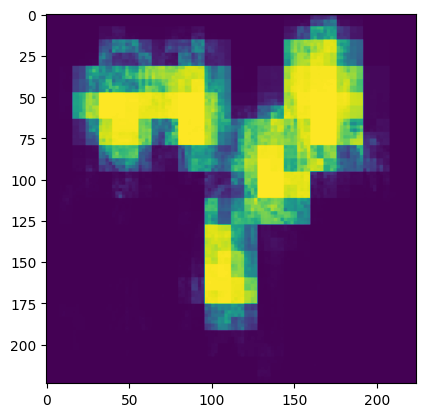

In [21]:
#Testing the model prediction on test image with index 3 in test data
# Printing the Original Image
print('The Original Image')
test_img = x_te[3]
plt.imshow(test_img)
plt.show()

#Printing the Masked Image
print('The Masked Image')
test_mask_img = y_te[3]
plt.imshow(test_mask_img)
plt.show()

#Printing the Predicted Mask Image
print('The Predicted Masked Image')
test_img = np.resize(test_img, (1, Img_Height, Img_Width, 3))
test_pred_mask_img = mobunet.predict(test_img)
test_pred_mask_img = np.resize(test_pred_mask_img, (Imgm_Height, Imgm_Width))
plt.imshow(test_pred_mask_img)
plt.show()

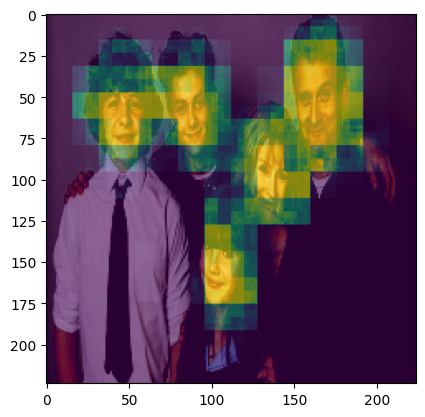

In [22]:
#Displaying the 'Predicted Mask' Image over the 'Original' Image
fig = plt.figure()
Orig_img = plt.imshow(np.resize(x_te[3], (Img_Height,Img_Width,3)))
Pred_img = plt.imshow(np.resize(test_pred_mask_img, (Imgm_Height, Imgm_Width)), alpha=0.6)
plt.show()